This tutorial taken from: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

# 1. Introduction
One of the primary applications of natural language processing is to automatically extract what topics people are discussing from large volumes of text. Some examples of large text could be feeds from social media, customer reviews of hotels, movies, etc, user feedbacks, news stories, e-mails of customer complaints etc.

Knowing what people are talking about and understanding their problems and opinions is highly valuable to businesses, administrators, political campaigns. And it’s really hard to manually read through such large volumes and compile the topics.

Thus is required an automated algorithm that can read through the text documents and automatically output the topics discussed.

In this tutorial, we will take a real example of the ’20 Newsgroups’ dataset and use LDA to extract the naturally discussed topics.

I will be using the Latent Dirichlet Allocation (LDA) from Gensim package along with the Mallet’s implementation (via Gensim). Mallet has an efficient implementation of the LDA. It is known to run faster and gives better topics segregation.

We will also extract the volume and percentage contribution of each topic to get an idea of how important a topic is.

Let’s begin!

# 2. Prerequisities: Download nltk stopwords and spacy model
We will need the stopwords from NLTK and spacy’s en model for text pre-processing. Later, we will be using the spacy model for lemmatization.

Lemmatization is nothing but converting a word to its root word. For example: the lemma of the word ‘machines’ is ‘machine’. Likewise, ‘walking’ –> ‘walk’, ‘mice’ –> ‘mouse’ and so on.

```python
# Run in python console
import nltk; nltk.download('stopwords')
```
    
   
```bash
# Run in terminal or command prompt
python3 -m spacy download en
```

# 3. Import packages
The core packages used in this tutorial are `re`, `gensim`, `spacy`, and `pyLDAvis`. Besides those, we will also use `matplotlib`, `numpy`, and `pandas` for data handling and visualization. Let's import them.

In [12]:
# Imports
import nltk
import re # Regular expressions
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# NLTK
from nltk.corpus import stopwords

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim # Don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR) 

# Ignore depreciation warnings 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)


# 4. What does LDA Do?
Fill this in.

# 5. Prepare Stopwords
We have already downloaded the stopwords. Let's import them and make them available in the variable `stop_words`.

In [5]:
# Prepare NLTK stop words
stop_words = stopwords.words('english')

# Add some other words to the list of stopwords
# These look like words likely to be found
# in email subject lines.
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# 6. Import newsgroups data
We will be using the 20-Newsgroups dataset for this exercise. This version of the dataset contains about 11,000 newsgroup posts from 20 different topics. This is available as [newsgroups.json](https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json).

In [6]:
# Import the data. From the tutorial:
# "This version of the dataset contains
# about 11k newsgroups posts from 20 different topics.
# This is available as newsgroups.json."
df = pd.read_json('https://raw.githubusercontent.com/selva86/datasets/master/newsgroups.json')

# Print names
print(df.target_names.unique())

# Return to the top of that file.
df.head()

['rec.autos' 'comp.sys.mac.hardware' 'rec.motorcycles' 'misc.forsale'
 'comp.os.ms-windows.misc' 'alt.atheism' 'comp.graphics'
 'rec.sport.baseball' 'rec.sport.hockey' 'sci.electronics' 'sci.space'
 'talk.politics.misc' 'sci.med' 'talk.politics.mideast'
 'soc.religion.christian' 'comp.windows.x' 'comp.sys.ibm.pc.hardware'
 'talk.politics.guns' 'talk.religion.misc' 'sci.crypt']


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
10,From: irwin@cmptrc.lonestar.org (Irwin Arnstei...,8,rec.motorcycles
100,From: tchen@magnus.acs.ohio-state.edu (Tsung-K...,6,misc.forsale
1000,From: dabl2@nlm.nih.gov (Don A.B. Lindbergh)\n...,2,comp.os.ms-windows.misc


# 7. Remove emails and newline characters.
As you can see, there are many emails, newline, and extra spaces that are quite distracting. Let's get rid of them using [regular expressions](https://www.machinelearningplus.com/python/python-regex-tutorial-examples/).

In [8]:
# Convert to list
data = df.content.values.tolist()

# Remove emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove newline characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

# Print something
pprint(data[:1])

['From: (wheres my thing) Subject: WHAT car is this!? Nntp-Posting-Host: '
 'rac3.wam.umd.edu Organization: University of Maryland, College Park Lines: '
 '15 I was wondering if anyone out there could enlighten me on this car I saw '
 'the other day. It was a 2-door sports car, looked to be from the late 60s/ '
 'early 70s. It was called a Bricklin. The doors were really small. In '
 'addition, the front bumper was separate from the rest of the body. This is '
 'all I know. If anyone can tellme a model name, engine specs, years of '
 'production, where this car is made, history, or whatever info you have on '
 'this funky looking car, please e-mail. Thanks, - IL ---- brought to you by '
 'your neighborhood Lerxst ---- ']


Note that even after removing the email addresses and extra spaces, the text still looks messy. It's not ready for the LDA to consume. Next, we will break down each sentence into a list of words through tokenization, while clearing up all the messy text in the process. Gensim's simple_preprocess is great for this.

# 8. Tokenize words and clean up text
Let's tokenize each sentence into a list of words, removing punctuation and unnecessary characters.

Gensim's `simple_preprocess()` is great for this. Additionally, we will set `deacc=True` to remove punctuation.


In [9]:
# Step 8: Tokenize words and clean up the text
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuation
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
# Convert the sentences to words.
data_words = list(sent_to_words(data))

# Print the updated list
print(data_words[:1])

[['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp', 'posting', 'host', 'rac', 'wam', 'umd', 'edu', 'organization', 'university', 'of', 'maryland', 'college', 'park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front', 'bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']]


# Step 9: Create bigram and trigram models. 
Bigrams are two words frequently occurring together in the document. Trigrams are three words occurring together. Examples: front_bumper, oil_leak, maryland_college_park Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [13]:
# Build the bigram and trigram models.
# Higher threshold -> fewer phrases
bigram  = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod  = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See a trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['from', 'wheres', 'my', 'thing', 'subject', 'what', 'car', 'is', 'this', 'nntp_posting_host', 'rac_wam_umd_edu', 'organization', 'university', 'of', 'maryland_college_park', 'lines', 'was', 'wondering', 'if', 'anyone', 'out', 'there', 'could', 'enlighten', 'me', 'on', 'this', 'car', 'saw', 'the', 'other', 'day', 'it', 'was', 'door', 'sports', 'car', 'looked', 'to', 'be', 'from', 'the', 'late', 'early', 'it', 'was', 'called', 'bricklin', 'the', 'doors', 'were', 'really', 'small', 'in', 'addition', 'the', 'front_bumper', 'was', 'separate', 'from', 'the', 'rest', 'of', 'the', 'body', 'this', 'is', 'all', 'know', 'if', 'anyone', 'can', 'tellme', 'model', 'name', 'engine', 'specs', 'years', 'of', 'production', 'where', 'this', 'car', 'is', 'made', 'history', 'or', 'whatever', 'info', 'you', 'have', 'on', 'this', 'funky', 'looking', 'car', 'please', 'mail', 'thanks', 'il', 'brought', 'to', 'you', 'by', 'your', 'neighborhood', 'lerxst']


# Step 10: Remove stopwords, make bigrams, and lemmatize
The bigrams model is ready. Let’s define the functions to remove the stopwords, make bigrams and lemmatization and call them sequentially.

In [14]:
# Define functions for stopwords, bigrams, and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc))\
            if word not in stop_words] for doc in texts]

# Make bigrams
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

# Make trigrams
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc\
                if token.pos_ in allowed_postags])
    return texts_out

Now let's call the functions in order.

In [15]:
# Remove stop words
data_words_nostops = remove_stopwords(data_words)

# Form bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization, keeping only noun, adjectives, verbs, and adverbs
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Print the lemmatized data
print(data_lemmatized[:1])

[['where', 's', 'thing', 'car', 'nntp_post', 'host', 'rac_wam', 'umd', 'organization', 'university', 'maryland_college', 'park', 'line', 'wonder', 'anyone', 'could', 'enlighten', 'car', 'see', 'day', 'door', 'sport', 'car', 'look', 'late', 'early', 'call', 'bricklin', 'door', 'really', 'small', 'addition', 'front_bumper', 'separate', 'rest', 'body', 'know', 'anyone', 'tellme', 'model', 'name', 'engine', 'spec', 'year', 'production', 'car', 'make', 'history', 'whatev', 'info', 'funky', 'look', 'car', 'mail', 'thank', 'bring', 'neighborhood', 'lerxst']]


# 11. Create the dictionary and corpus needed for topic modeling
The two main inputs to the LDA topic model are the dictionary (`id2word`) and the corpus. Let's create them.

In [16]:
# Create dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create corpus
texts = data_lemmatized

# Term document frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 2), (2, 1), (3, 1), (4, 1), (5, 1), (6, 5), (7, 1), (8, 1), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 1), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 1), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 1), (50, 1)]]


Gensim creates a unique ID for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies word ID 0 occurs once in the first document. Likewise, word ID 1 occurs twice, and so on.

This is used as the input to the LDA model.

If you want to see what word a given ID corresponds to, pass the ID as a key to the dictionary

In [17]:
id2word[0]

'addition'

Or, you can see a human-readable form of the corpus itself.

In [69]:
# Human-readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('addition', 1),
  ('anyone', 2),
  ('body', 1),
  ('bricklin', 1),
  ('bring', 1),
  ('call', 1),
  ('car', 5),
  ('could', 1),
  ('day', 1),
  ('door', 2),
  ('early', 1),
  ('engine', 1),
  ('enlighten', 1),
  ('front_bumper', 1),
  ('funky', 1),
  ('history', 1),
  ('host', 1),
  ('info', 1),
  ('know', 1),
  ('late', 1),
  ('lerxst', 1),
  ('line', 1),
  ('look', 2),
  ('mail', 1),
  ('make', 1),
  ('maryland_college', 1),
  ('model', 1),
  ('name', 1),
  ('neighborhood', 1),
  ('nntp_post', 1),
  ('organization', 1),
  ('park', 1),
  ('production', 1),
  ('rac_wam', 1),
  ('really', 1),
  ('rest', 1),
  ('s', 1),
  ('see', 1),
  ('separate', 1),
  ('small', 1),
  ('spec', 1),
  ('sport', 1),
  ('tellme', 1),
  ('thank', 1),
  ('thing', 1),
  ('umd', 1),
  ('university', 1),
  ('whatev', 1),
  ('where', 1),
  ('wonder', 1),
  ('year', 1)]]

Alright, without digressing further, let's jump back on track with the next step: Building the topic model.

# 12. Building the Topic Model
We have everything required to train the LDA model. In addition to the corpus and dictionary, you need to provide the number of topics as well.

Apart from that, `alpha` and `eta` are hyperparameters that affect sparsity of the topics. According to the gensim docs, both default to priors of 1.0/`num_topics`.

`chunksize` is the number of documents to be used in each training chunk.

`update_every` determines how often the model parameters should be updated.

`passes` is the total number of training passes.

In [20]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=20,
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# 13. View the topics in the LDA model
The above LDA model is built with 20 different topics, where each topic is a combination of keywords and each keyword contributes a certain weight to the topic.

You can see the keywords for each topic and the weighting (importance) of each keyword using `lda_model.print_topics()` as shown next.

In [21]:
# Print the keywords
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"_" + 0.029*"blue" + 0.021*"tank" + 0.014*"cubs_suck" + 0.012*"eg" + '
  '0.012*"gas" + 0.011*"hi" + 0.007*"henry_spencer" + 0.007*"cigarette" + '
  '0.006*"xlib"'),
 (1,
  '0.020*"value" + 0.020*"bus" + 0.019*"specifically" + 0.015*"function" + '
  '0.015*"associate" + 0.013*"motorcycle" + 0.011*"properly" + 0.010*"code" + '
  '0.008*"confuse" + 0.008*"error"'),
 (2,
  '0.023*"window" + 0.020*"card" + 0.017*"file" + 0.014*"drive" + 0.013*"use" '
  '+ 0.013*"system" + 0.011*"problem" + 0.010*"run" + 0.009*"color" + '
  '0.009*"do"'),
 (3,
  '0.035*"game" + 0.033*"team" + 0.019*"player" + 0.017*"play" + 0.017*"win" + '
  '0.016*"hockey" + 0.013*"season" + 0.011*"contact" + 0.011*"year" + '
  '0.010*"nhl"'),
 (4,
  '0.026*"wire" + 0.017*"circuit" + 0.015*"faq" + 0.015*"connect" + '
  '0.013*"wiring" + 0.013*"voice" + 0.013*"cover" + 0.011*"outlet" + '
  '0.011*"neutral" + 0.010*"conference"'),
 (5,
  '0.030*"government" + 0.024*"gun" + 0.022*"law" + 0.017*"state" + '
  '0.0

Ok... so how do we interpret this?

Topic 0 is represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

(this will change depending on your random seed).

It means the top 10 keywords that contribute to this topic are: 'car', 'power', 'light', ... and so on, and the weight of 'car' in topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may surmise that it's either "cars" or "automobiles."

Likewise, can you go through the temaining topic keywords and judge what their topics are?

# 14. Compute model perplexity and coherence score.
Model perplexity and [topic coherence](https://rare-technologies.com/what-is-topic-coherence/) provide a convenient measure to judge how good a given topic model is. Some people think that topic coherence score is the more helpful of the two.

In [22]:
# Compute perplexity - a measure of how good the model is.
# Lower is better.
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

# Compute coherence score
coherence_model_lda = CoherenceModel(model=lda_model,
                                     texts=data_lemmatized,
                                     dictionary=id2word,
                                     coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.754094958488817

Coherence Score:  0.515758393754623


So we have a coherence score of about 0.5.

# 15. Visualize the topics-keywords
Now that the LDA model is built, the next step is to examine the produced topics and associated keywords. There is no better tool than pyLDAvis package's interactive chart, which is designed to work well with jupyter notebooks.

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.336888  0.001184       1        1  16.246342
13     0.291056  0.003224       2        1  15.224774
18     0.328826  0.128115       3        1  14.578359
2      0.091706 -0.226509       4        1   6.162324
15     0.059626 -0.222493       5        1   5.974188
10    -0.085008  0.113080       6        1   4.344127
17     0.060780  0.183152       7        1   4.177505
12    -0.021523  0.036644       8        1   3.603456
5     -0.022913  0.021302       9        1   3.365237
16    -0.029276 -0.219698      10        1   3.271751
6     -0.062997  0.016655      11        1   3.222973
9     -0.062895 -0.139420      12        1   2.968408
14    -0.088884  0.062651      13        1   2.740005
3     -0.047744  0.117435      14        1   2.731156
8     -0.111453 -0.003686      15        1   2.292013
19    -0.113682  0.023411      16        1   2.124451
11    -0.092438  0.110488      17        1   2.077307
4     -0.134205 -0.001626      18        1   1.694619
0     -0.164222  0.028030      19        1   1.679201
1     -0.131641 -0.031941      20        1   1.521806, topic_info=      Category          Freq          Term         Total  loglift  logprob
term                                                                      
4146   Default  57084.000000            ax  57084.000000  30.0000  30.0000
21     Default  12491.000000          line  12491.000000  29.0000  29.0000
82     Default  16291.000000           not  16291.000000  28.0000  28.0000
30     Default  11142.000000  organization  11142.000000  27.0000  27.0000
3721   Default   3844.000000           max   3844.000000  26.0000  26.0000
65     Default  10452.000000            do  10452.000000  25.0000  25.0000
322    Default   9655.000000         write   9655.000000  24.0000  24.0000
55     Default   7586.000000       article   7586.000000  23.0000  23.0000
244    Default   8046.000000            be   8046.000000  22.0000  22.0000
154    Default  11782.000000         would  11782.000000  21.0000  21.0000
303    Default   6905.000000           say   6905.000000  20.0000  20.0000
226    Default   5803.000000            go   5803.000000  19.0000  19.0000
29     Default   4407.000000     nntp_post   4407.000000  18.0000  18.0000
16     Default   4083.000000          host   4083.000000  17.0000  17.0000
118    Default   6852.000000           get   6852.000000  16.0000  16.0000
46     Default   5027.000000    university   5027.000000  15.0000  15.0000
1911   Default   1863.000000         space   1863.000000  14.0000  14.0000
215    Default   2294.000000        window   2294.000000  13.0000  13.0000
36     Default   3735.000000             s   3735.000000  12.0000  12.0000
18     Default   7291.000000          know   7291.000000  11.0000  11.0000
50     Default   3461.000000          year   3461.000000  10.0000  10.0000
317    Default   4598.000000           use   4598.000000   9.0000   9.0000
2726   Default   1540.000000          game   1540.000000   8.0000   8.0000
23     Default   1949.000000          mail   1949.000000   7.0000   7.0000
681    Default   3006.000000         right   3006.000000   6.0000   6.0000
967    Default   1685.000000     christian   1685.000000   5.0000   5.0000
1362   Default   1746.000000    government   1746.000000   4.0000   4.0000
567    Default   1464.000000          team   1464.000000   3.0000   3.0000
206    Default   3380.000000        system   3380.000000   2.0000   2.0000
60     Default   2012.000000          card   2012.000000   1.0000   1.0000
...        ...           ...           ...           ...      ...      ...
11736  Topic20    119.370544          guru    120.322456   4.1773  -5.3260
3548   Topic20    117.623055  countersteer    118.574966   4.1772  -5.3407
10436  Topic20    113.025719       bradley    113.977631   4.1769  -5.3806
280    Topic20    112.216385          lane    113.168297   4.1768  -5

So how do we interpret the output of pyLDAvis?

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic. A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant. A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.

Alright, if you move the cursor over one of the bubbles, the words and bars on the right-hand side will update. These words are the salient keywords that form the selected topic. 

We have successfully built a good-looking topic model.

Given our prior knowledge of the number of natural topics in the document, finding the best model was fairly straightforward.

Up next, we will improve upon this model by using Mallet’s version of LDA algorithm and then we will focus on how to arrive at the optimal number of topics given any large corpus of text.


# 16. Building an LDA Mallet Model
So far we've seen Gensim's built-in version of the LDA algorithm. Mallet's version, however, often gives better quality topics.

Gensim provices a wrapper to implement Mallet's LDA from within Gensim itself. You only need to [download](https://www.machinelearningplus.com/wp-content/uploads/2018/03/mallet-2.0.8.zip) the zipfile, unzip it, and provide the path to `mallet` in the unzipped directory to `gensim.models.wrappers.LdaMallet`.

Download the file by running the following in a shell:

```bash
wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip && unzip mallet-2.0.8.zip
```
Or download and unzip it manually from http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip



In [24]:
# Specify the path to mallet
mallet_path = 'mallet-2.0.8/bin/mallet' # update this path to wherever you downloaded the files to

# Point gensim to mallet
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path,
                                             corpus=corpus,
                                             num_topics=20,
                                             id2word=id2word)

In [25]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute coherence score
coherence_model_ldamallet = CoherenceModel(model=ldamallet,
                                           texts=data_lemmatized,
                                           dictionary=id2word,
                                           coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()

# Print the score
print('\nCoherence Score: ', coherence_ldamallet)


[(9,
  [('drive', 0.022915385045579106),
   ('card', 0.01733683798445277),
   ('problem', 0.016651753257647783),
   ('system', 0.015183714557351378),
   ('scsi', 0.012373469045355405),
   ('driver', 0.011814216207147251),
   ('mac', 0.011506627146132766),
   ('window', 0.011492645825177563),
   ('work', 0.010108495050612383),
   ('run', 0.009772943347687489)]),
 (3,
  [('armenian', 0.016366586330198635),
   ('people', 0.010160200368602618),
   ('war', 0.009671880660964353),
   ('world', 0.00919931320195958),
   ('turkish', 0.00745081360364192),
   ('history', 0.006663201171967299),
   ('turk', 0.006033111226627601),
   ('government', 0.005623552762156798),
   ('greek', 0.005576296016256321),
   ('turkey', 0.005340012286753934)]),
 (1,
  [('make', 0.015761403136360017),
   ('work', 0.012272136280414998),
   ('money', 0.011157693634409743),
   ('year', 0.01102502189083769),
   ('people', 0.00987077772176082),
   ('president', 0.009194151829543343),
   ('job', 0.00790723591689442),
   ('p

Just by changing the LDA algorithm, we increased the coherence score from about 0.5 to over 0.6. Not bad!

# 17. How to find the optimal number of topics for LDA?
One approach to finding the optimal number of topics is to build many LDA models with different numbers of topics (`k`) and pick the one that gives the highest coherence value.

Choosing a value of `k` that marks the end of a rapic growth of topic coherence usually offers meaningful and interpretable topics. Picking an ever higher value can sometimes provide more granular sub-topics.

If you see the same keywords being repeated in multiple topics, it's probably a sign that `k` is too large.

The function `compute_coherence_values()` (see below) trains multiple LDA models and returns the models and their corresponding coherence scores.

In [26]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various numbers of topics
    
    Parameters:
    -----------
    dictionary : Gensim dictionary
    corpus     : Gensim corpus
    texts      : list of input texts
    limit      : Max number of topics
    
    Returns:
    -----------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    # Print out the variables
    print("Start = %d\nLimit = %d\nStep = %d\n" % (start, limit, step))
    
    # Instantiate lists to hold coherence values and models
    coherence_values = []
    model_list = []
    
    # Start a counter
    counter = 0
    
    # Topic numbers
    topic_nums = range(start, limit, step)
    
    # Loop over all the numbers of topics
    for num_topics in topic_nums:
        
        # Increment the counter
        counter += 1
        
        # Inform the user 
        print("On iteration %d of %d" % (counter, len(topic_nums)))
        
        # Generate the LDA model
        model = gensim.models.wrappers.LdaMallet(mallet_path,
                                                corpus=corpus,
                                                num_topics=num_topics,
                                                id2word=id2word)
        
        # Append the model to the list of models
        model_list.append(model)
        
        # Generate a coherence model
        coherencemodel = CoherenceModel(model=model,
                                       texts=texts,
                                       dictionary=dictionary,
                                       coherence='c_v')
        
        # Append the coherence value to the list of values
        coherence_values.append(coherencemodel.get_coherence())
             
    # Return the lists of models and coherence values
    return model_list, coherence_values
        


In [27]:
# Train LDA models with different numbers of topics.
# This can take a while to run – this would be a good time to take a break.

model_list, coherence_values = compute_coherence_values(dictionary=id2word,
                                                       corpus=corpus,
                                                       texts=data_lemmatized,
                                                       start=2,
                                                       limit=40,
                                                       step=6)

Start = 2
Limit = 40
Step = 6

On iteration 1 of 7
On iteration 2 of 7
On iteration 3 of 7
On iteration 4 of 7
On iteration 5 of 7
On iteration 6 of 7
On iteration 7 of 7


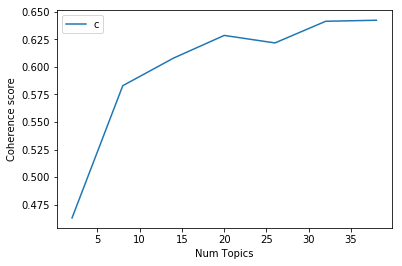

In [28]:
# Plot the results
limit = 40
start = 2
step = 6
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [29]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics = ", m, " has coherence value of ", round(cv, 4))

Num Topics =  2  has coherence value of  0.4629
Num Topics =  8  has coherence value of  0.5829
Num Topics =  14  has coherence value of  0.6079
Num Topics =  20  has coherence value of  0.6285
Num Topics =  26  has coherence value of  0.6217
Num Topics =  32  has coherence value of  0.6414
Num Topics =  38  has coherence value of  0.6423


If the coherence value (CV) seems to keep increasing, it may make better sense to pick the model that gave the highest CV before flattening out. This is exactly the case here. 

So for further steps, let's choose the model with 20 topics.

In [31]:
# Select the model and print the topics
optimal_model = model_list[3]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.024*"window" + 0.018*"file" + 0.013*"program" + 0.012*"line" + '
  '0.010*"set" + 0.009*"server" + 0.008*"run" + 0.008*"application" + '
  '0.007*"display" + 0.007*"entry"'),
 (1,
  '0.104*"line" + 0.099*"organization" + 0.088*"write" + 0.073*"article" + '
  '0.073*"nntp_post" + 0.063*"host" + 0.059*"university" + 0.028*"reply" + '
  '0.011*"distribution_world" + 0.010*"usa"'),
 (2,
  '0.023*"gun" + 0.010*"state" + 0.009*"make" + 0.009*"bill" + 0.008*"year" + '
  '0.008*"pay" + 0.008*"thing" + 0.008*"weapon" + 0.007*"firearm" + '
  '0.007*"money"'),
 (3,
  '0.029*"key" + 0.012*"system" + 0.011*"encryption" + 0.009*"government" + '
  '0.008*"security" + 0.008*"bit" + 0.008*"message" + 0.008*"chip" + '
  '0.008*"information" + 0.008*"technology"'),
 (4,
  '0.024*"drive" + 0.018*"card" + 0.018*"problem" + 0.014*"system" + '
  '0.013*"scsi" + 0.012*"driver" + 0.011*"mac" + 0.011*"bit" + 0.010*"window" '
  '+ 0.009*"work"'),
 (5,
  '0.019*"armenian" + 0.012*"people" + 0.008*"world

Those were the topics for the chosen LDA model.

# 18. Finding the dominant topic in each sentence
One of the practical applications of topic modeling is to determine what topic a given document is about. To do that, we find the topic number that has the highest percentage contribution in that document.  The `format_topics_sentences()` function below nicely aggregates this information in a presentable table.

In [40]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    
    # Initialize output
    sent_topics_df = pd.DataFrame()
    
    # Get the main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        
        # Get the dominant topic, percent contribution
        # and keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)        
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)
    
# Find the topic number that has the 
# highest percentage contribution to each document
df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show results
df_dominant_topic.head(10)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,9.0,0.1819,"car, article, write, bike, line, good, organiz...",From: (wheres my thing) Subject: WHAT car is t...
1,1,4.0,0.1747,"drive, card, problem, system, scsi, driver, ma...",From: (Guy Kuo) Subject: SI Clock Poll - Final...
2,2,9.0,0.3485,"car, article, write, bike, line, good, organiz...",From: (Irwin Arnstein) Subject: Re: Recommenda...
3,3,10.0,0.3624,"file, image, software, version, program, syste...",From: (Tsung-Kun Chen) Subject: ** Software fo...
4,4,4.0,0.2434,"drive, card, problem, system, scsi, driver, ma...",From: (Don A.B. Lindbergh) Subject: Diamond SS...
5,5,9.0,0.4710,"car, article, write, bike, line, good, organiz...",From: (Robert Loper) Subject: Re: SHO and SC N...
6,6,1.0,0.1770,"line, organization, write, article, nntp_post,...",From: (Kim Richard Man) Subject: SyQuest 44M c...
7,7,12.0,0.1803,"post, mail, send, university, information, lis...",From: (Kirtley Wilson) Subject: Mirosoft Offic...
8,8,15.0,0.2121,"people, law, write, state, article, make, case...",Subject: Re: Dont more innocents die without t...
9,9,19.0,0.2591,"question, point, thing, make, good, write, exi...",From: (Jon Livesey) Subject: Re: Genocide is C...


# 19. Find the most representative document for each topic
Sometimes just the topic keywords may not be enough to make sense of what a topic is about. So, to help with understanding the topic, you can find the documents to which a given topic has contributed most, and then infer the topic by reading that document.

In [94]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

# Sort by dominant topic
sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)
    
# Reset index
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
sent_topics_sorteddf_mallet.head()


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9623,"window, file, program, line, set, server, run,...",From: (Landon C. Noll) Subject: 10th Internati...
1,1.0,0.4700,"line, organization, write, article, nntp_post,...",From: (Bradley T Banko) Subject: Save my hard ...
2,2.0,0.7311,"gun, state, make, bill, year, pay, thing, weap...",From: (Steve Manes) Subject: Re: Gun Control (...
3,3.0,0.9125,"key, system, encryption, government, security,...",From: (Clipper Chip Announcement) Subject: tex...
4,4.0,0.8266,"drive, card, problem, system, scsi, driver, ma...",From: (D. Keith Rice) Subject: Re: Drive/Contr...


The tabular output above actually has 20 rows, one each topic. It has the topic number, the keywords, and the most representative document. 

The `Perc_Contribution` column is nothing but the percentage contribution of the topic in the given document.

# 20. Topic distribution across documents
Finally, we want to understand the volume and distribution of topics in order to judge how widely each was discussed. The table below shows that information.

In [130]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(20)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0,9.0,"car, article, write, bike, line, good, organiz...",575.0,0.0508
1,4.0,"drive, card, problem, system, scsi, driver, ma...",757.0,0.0669
2,9.0,"car, article, write, bike, line, good, organiz...",447.0,0.0395
3,10.0,"file, image, software, version, program, syste...",543.0,0.0480
4,4.0,"drive, card, problem, system, scsi, driver, ma...",1314.0,0.1161
5,9.0,"car, article, write, bike, line, good, organiz...",252.0,0.0223
6,1.0,"line, organization, write, article, nntp_post,...",1076.0,0.0951
7,12.0,"post, mail, send, university, information, lis...",539.0,0.0476
8,15.0,"people, law, write, state, article, make, case...",813.0,0.0719
9,19.0,"question, point, thing, make, good, write, exi...",1070.0,0.0946
